In [1]:
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('월별 총물동량2.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(267, 15)


,TEU,BDI,HRCI,ln(HRCI),무역수지,평균국제유가,평균미국달러환율,운송수지,경상수지,경기종합지수,수출물가지수,수입물가지수,부산항수출금액,부산항수입금액,경제심리지수
Date,,,,,,,,,,,,,,,
2000-01-31,464000,1319,580.7527,2.763991,-432198,25.22,"1,131.07",85.6,-218.1,58.5,133.88,75.60,5140310,3605241,101.6
2000-02-29,480000,1531,571.2076,2.756794,652390,27.02,"1,128.80",91.1,-324.1,58.7,130.56,75.92,4984788,3321729,101.5
2000-03-31,541000,1660,562.7186,2.750291,217692,27.40,"1,117.19",144.3,275.3,59.0,128.19,75.88,6047778,4080972,101.4
2000-04-30,491000,1628,554.5744,2.743960,177508,23.62,"1,109.76",174.7,-1156.0,58.8,126.84,73.88,5593812,3823350,101.5
2000-05-31,556000,1566,549.0330,2.739598,1353399,27.37,"1,120.01",57.3,1535.5,58.8,127.89,75.46,5914069,3908017,101.4


In [4]:
#data.dtypes --> float type 확인
data['평균미국달러환율'] = (data['평균미국달러환율'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
#data.dtypes # object로 잘못 인식한 데이터 float로 조정 

In [5]:
split = -63
train_data = data['TEU'][0:split] # 2000.01 ~ 2016.12
test_data = data['TEU'][split:] # 2017.01. ~ 2022.03

In [6]:
train_data.shape,test_data.shape

((204,), (63,))

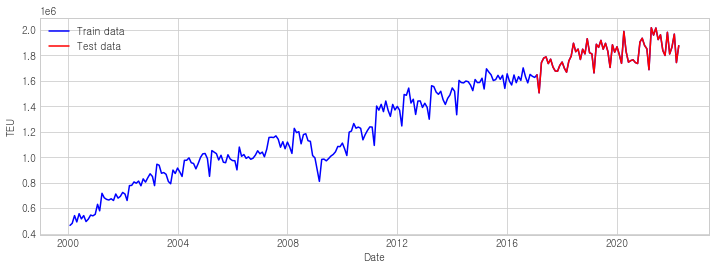

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

### 1.)  ARIMAX ( Seasonal ARIMAX)

In [152]:
split = -63
Ex_train_data = data[0:split]
exog_train = Ex_train_data[['BDI','무역수지','경기종합지수','경상수지','부산항수출금액','부산항수입금액','수출물가지수']]

In [153]:
split = -63
Ex_test_data = data[split:]
exog_test = Ex_test_data[['BDI','무역수지','경기종합지수','경상수지','부산항수출금액','부산항수입금액','수출물가지수']]

In [154]:
sarimax = auto_arima(train_data,start_p=1,start_q=1,
                             max_p=5,max_q=5,m=12,seasonal=True,
                             d=1,D=1,
                             max_P=5,max_Q=5,
                             trace=False,
                             error_action='ignore',
                             suppress_warnings=True,
                            exogenous=exog_train,
                             stepwise=True) # stepwise = True 

In [155]:
sarimax

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [156]:
sarimax = sm.tsa.statespace.SARIMAX(train_data,order=(0,1,1),seasonal_order=(0,1,1,12),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='M').fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                TEU   No. Observations:                  204
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2140.147
Date:                            Fri, 27 May 2022   AIC                           4300.293
Time:                                    02:57:29   BIC                           4332.055
Sample:                                01-31-2000   HQIC                          4313.175
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BDI            4.6447      6.583      0.706      0.480      -8.258      17.548
무역수지          -0.0017      0.004     -0.446      0.656      -0.009       0.006
경기종합지수      3677.6927   4054.474      0.907      0.364   -4268.930    1.16e+04
경상수지           1.6904      2.328      0.726      0.468      -2.872       6.253
부산항수출금액       -0.0020      0.013     -0.151      0.880      -0.027       0.023
부산항수입금액        0.0338      0.016      2.115      0.034       0.002       0.065
수출물가지수      1841.9303   1505.194      1.224      0.221   -1108.195    4792.056
ma.L1         -0.5125      0.096     -5.328      0.000      -0.701      -0.324
ma.S.L12      -0.7500      0.082     -9.186      0.000      -0.910      -0.590
sigma2      2.619e+09      0.000   9.78e+12      0.000    2.62e+09    2.62e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.96   Prob(JB):                         0.51
Heteroskedasticity (H):               2.07   Skew:                            -0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.51e+30. Standard errors may be unstable.
"""

In [157]:
tr_start,tr_end = '2000-01-31','2016-12-31'
te_start,te_end = '2017-01-01','2022-03-31'

In [158]:
pred = sarimax.predict(te_start,te_end,exog = exog_test)

MSE: 4242048215.5507526
MAE: 52911.24781029915
RMSE: 65131.00809561259
MAPE: 2.8940377307574363


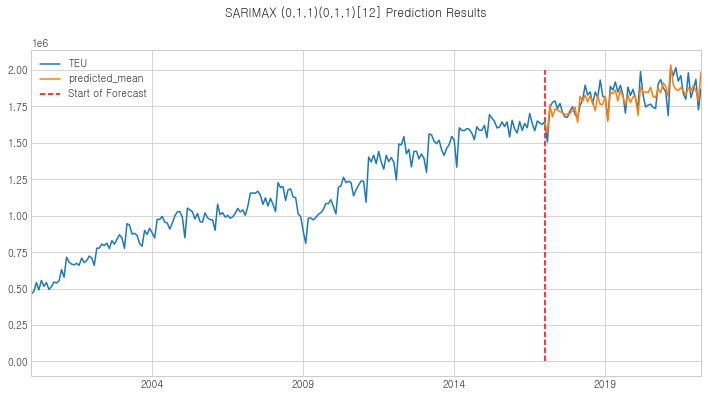

In [159]:
full_data_evaluation = pd.concat([data['TEU'], pred], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01',0,2000000,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 12, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle(f'SARIMAX (0,1,1)(0,1,1)[12] Prediction Results')



mse = mean_squared_error(test_data, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, pred))
print('RMSE: '+str(rmse))
print('MAPE:',np.mean(np.abs((test_data-pred)/test_data)*100) )

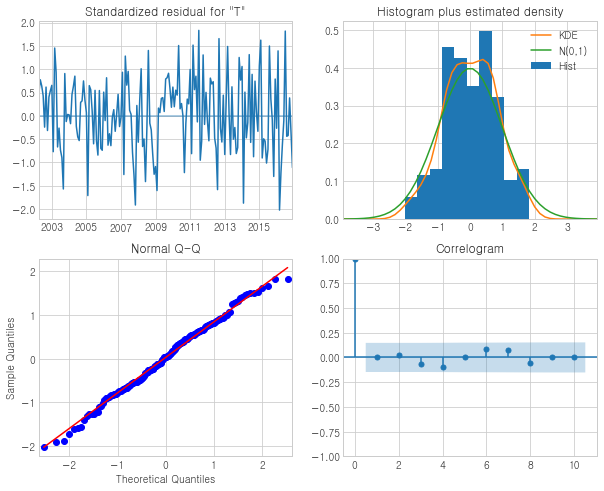

In [160]:
sarimax.plot_diagnostics(figsize=(10,8))
plt.show()

### 2. 다변량 LSTM

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [10]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [11]:
raw_df = pd.read_csv('월별 총물동량2.csv')

#data.dtypes --> float type 확인
raw_df['평균미국달러환율'] = (raw_df['평균미국달러환율'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
#data.dtypes # object로 잘못 인식한 데이터 float로 조정 

In [12]:
split = -64
train = raw_df[0:split] # 2000.01 ~ 2016.12
test = raw_df[split:] # 2017.01. ~ 2022.03

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols =  ['TEU','BDI','ln(HRCI)','무역수지','경기종합지수','경상수지','부산항수출금액','부산항수입금액','수출물가지수']

scaled_train = scaler.fit_transform(train[scale_cols])
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)
feature_train = scaled_train # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']] # y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols])
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)
feature_test = scaled_test # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']] # y_test 종속변수 

print(scaled_train.shape,scaled_test.shape)
print(label_train.shape,label_test.shape)

(203, 9) (64, 9)
(203, 1) (64, 1)


In [14]:
# DataFrame => Numpy 변환 1. X_train,Y_train
feature_train_np = feature_train.to_numpy() # 다변량 시계열 변수 
label_train_np = label_train.to_numpy()     # 종속변수 (예측값)

print(feature_train_np.shape, label_train_np.shape)

(203, 9) (203, 1)


In [15]:
# DataFrame => Numpy 변환 2. X_test,Y_test
feature_test_np = feature_test.to_numpy() # 다변량 시계열 변수 
label_test_np = label_test.to_numpy()     # 종속변수 (예측값)

print(feature_test_np.shape, label_test_np.shape)

(64, 9) (64, 1)


In [16]:
def make_sequence_dataset(feature, label, window_size): # (Batch Size, Feature 개수,Time Step)

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list) # 3차원 데이터로 변경 

In [17]:
window_size = 1

X_train, y_train = make_sequence_dataset(feature_train_np, label_train_np, window_size) 

print(X_train.shape, y_train.shape) 

(202, 1, 9) (202, 1)


In [18]:
window_size = 1

X_test, y_test = make_sequence_dataset(feature_test_np, label_test_np, window_size) 

print(X_test.shape, y_test.shape) 

(63, 1, 9) (63, 1)


In [19]:
model=Sequential()
model.add(LSTM(64,input_shape=(1,9),activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) 
model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
model.fit(X_train, y_train,validation_split=0.02,epochs=40, batch_size=2)

Epoch 1/40
99/99 [==============================] - 9s 58ms/step - loss: 0.1824 - mae: 0.3384 - val_loss: 0.0128 - val_mae: 0.1108
Epoch 2/40
99/99 [==============================] - 0s 4ms/step - loss: 0.0112 - mae: 0.0840 - val_loss: 0.0010 - val_mae: 0.0282
Epoch 3/40
99/99 [==============================] - 0s 4ms/step - loss: 0.0058 - mae: 0.0588 - val_loss: 9.1670e-04 - val_mae: 0.0240
Epoch 4/40
99/99 [==============================] - 0s 3ms/step - loss: 0.0066 - mae: 0.0662 - val_loss: 0.0010 - val_mae: 0.0263
Epoch 5/40
99/99 [==============================] - 0s 3ms/step - loss: 0.0052 - mae: 0.0554 - val_loss: 6.5516e-04 - val_mae: 0.0216
Epoch 6/40
99/99 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0648 - val_loss: 0.0016 - val_mae: 0.0347
Epoch 7/40
99/99 [==============================] - 0s 4ms/step - loss: 0.0051 - mae: 0.0544 - val_loss: 5.8892e-04 - val_mae: 0.0205
Epoch 8/40
99/99 [==============================] - 0s 4ms/step - loss: 0.004

In [20]:
prediction = model.predict(X_test)
prediction_copies_array = np.repeat(prediction,9, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),9)))[:,0]
original_copies_array = np.repeat(y_test,9, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),9)))[:,0]

future_forecast_dl = pred
future_forecast_dl = pd.DataFrame(future_forecast_dl, index=test_data[:].index, columns=['prediction'])

MSE: 7069260031.108383
MAE: 65384.2876984127
RMSE: 84078.89170956277
MAPE: 3.5963557150954135


Text(0.5, 0.98, 'Multivariate LSTM Prediction Results')

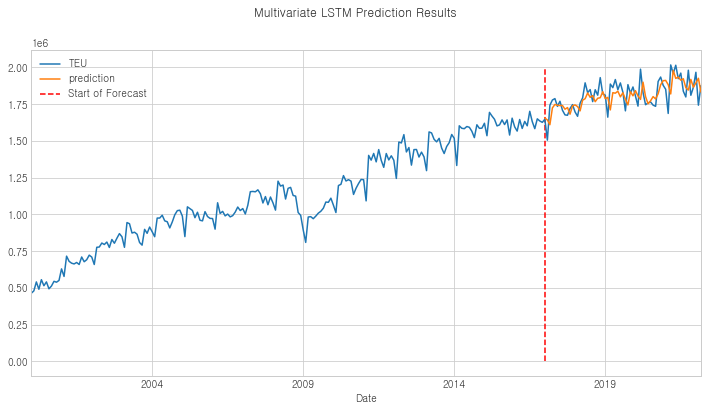

In [22]:
mse = mean_squared_error(original, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(original, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(pred, original))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs((original-pred)/original)*100)
print('MAPE: '+str(mape))

full_data_evaluation = pd.concat([data['TEU'], future_forecast_dl], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01',0,2000000,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 12, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle('Multivariate LSTM Prediction Results')

In [39]:
scaled_test.tail(1) # --> 2022.04 TEU 예측을 위한 입력값 

,TEU,BDI,ln(HRCI),무역수지,경기종합지수,경상수지,부산항수출금액,부산항수입금액,수출물가지수
63,0.724092,0.399786,1.0,0.254449,1.0,0.677285,0.605264,0.230819,1.0


In [40]:
ar = np.array([[[0.724092,0.399786,1.0,0.254449,1.0,0.677285, 0.605264, 0.230819,1.0]]]) # 2022.03 입변수 정규화값 
ar.shape # X_test.shape와 동일 

(1, 1, 9)

In [41]:
predict_next = model.predict(ar)
predict_next_array = np.repeat(predict_next,9, axis=-1)
pred_next_value = scaler.inverse_transform(np.reshape(predict_next_array,(len(predict_next),9)))[:,0]
print('2022-04 부산항 TEU 예측값:',pred_next_value) # 1개월 후 TEU 예측 

2022-04 부산항 TEU 예측값: [1889183.]


### 3.) GRU

In [82]:
model=Sequential()
model.add(GRU(64,input_shape=(1,9),activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) 
model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
model.fit(X_train, y_train,validation_split=0.1,epochs=40, batch_size=2)

Epoch 1/40
91/91 [==============================] - 2s 7ms/step - loss: 0.0778 - mae: 0.2068 - val_loss: 0.0181 - val_mae: 0.1290
Epoch 2/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0095 - mae: 0.0753 - val_loss: 0.0083 - val_mae: 0.0820
Epoch 3/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0074 - mae: 0.0717 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 4/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0067 - mae: 0.0653 - val_loss: 0.0022 - val_mae: 0.0377
Epoch 5/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0065 - mae: 0.0629 - val_loss: 0.0026 - val_mae: 0.0423
Epoch 6/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0071 - mae: 0.0677 - val_loss: 0.0037 - val_mae: 0.0532
Epoch 7/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0081 - mae: 0.0717 - val_loss: 0.0024 - val_mae: 0.0412
Epoch 8/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0048 - mae: 0.05

MSE: 8164325741.193045
MAE: 70285.46774193548
RMSE: 90356.65853268947
MAPE: 3.862195864653407


Text(0.5, 0.98, 'Multivariate GRU Prediction Results')

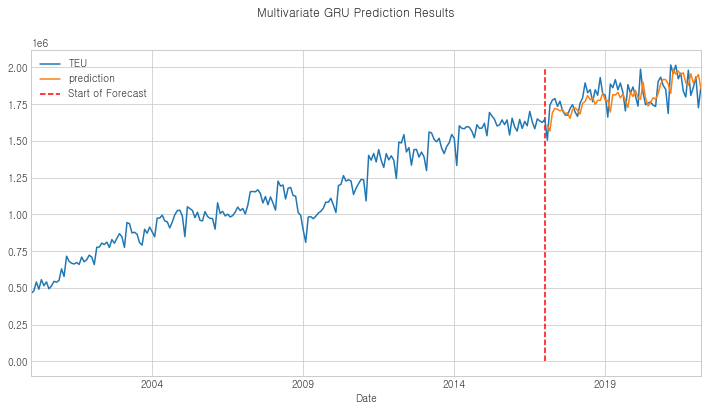

In [83]:
prediction = model.predict(X_test)
prediction_copies_array = np.repeat(prediction,9, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),9)))[:,0]
original_copies_array = np.repeat(y_test,9, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),9)))[:,0]

future_forecast_dl = pred
future_forecast_dl = pd.DataFrame(future_forecast_dl, index=test_data[1:].index, columns=['prediction'])

mse = mean_squared_error(original, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(original, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(pred, original))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs((original-pred)/original)*100)
print('MAPE: '+str(mape))

full_data_evaluation = pd.concat([data['TEU'], future_forecast_dl], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01',0,2000000,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 12, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle('Multivariate GRU Prediction Results')

### 4. Bidirectional LSTM

In [84]:
model=Sequential()
model.add(Bidirectional(LSTM(64,input_shape=(1,9),activation='tanh',return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) 
model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
model.fit(X_train, y_train,validation_split=0.1,epochs=40, batch_size=2)

Epoch 1/40
91/91 [==============================] - 5s 18ms/step - loss: 0.1167 - mae: 0.2554 - val_loss: 0.0254 - val_mae: 0.1526
Epoch 2/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0758 - val_loss: 0.0040 - val_mae: 0.0527
Epoch 3/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0060 - mae: 0.0578 - val_loss: 0.0027 - val_mae: 0.0407
Epoch 4/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0054 - mae: 0.0584 - val_loss: 0.0032 - val_mae: 0.0468
Epoch 5/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0521 - val_loss: 0.0020 - val_mae: 0.0372
Epoch 6/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0065 - mae: 0.0652 - val_loss: 0.0084 - val_mae: 0.0826
Epoch 7/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0062 - mae: 0.0658 - val_loss: 0.0021 - val_mae: 0.0366
Epoch 8/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0050 - mae: 0.0

In [85]:
import warnings 
warnings.filterwarnings(action='ignore')

MSE: 8469479984.394405
MAE: 71542.44556451614
RMSE: 92029.77770479729
MAPE: 3.922026676913921


Text(0.5, 0.98, 'Multivariate Bidirectional LSTM Prediction Results')

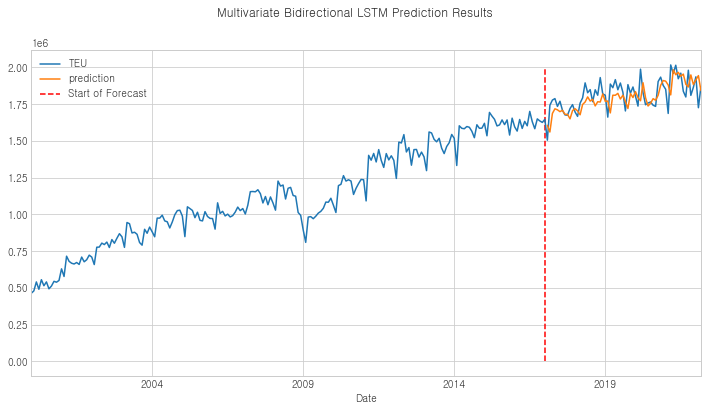

In [86]:
prediction = model.predict(X_test)
prediction_copies_array = np.repeat(prediction,9, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),9)))[:,0]
original_copies_array = np.repeat(y_test,9, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),9)))[:,0]

future_forecast_dl = pred
future_forecast_dl = pd.DataFrame(future_forecast_dl, index=test_data[1:].index, columns=['prediction'])

mse = mean_squared_error(original, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(original, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(pred, original))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs((original-pred)/original)*100)
print('MAPE: '+str(mape))

full_data_evaluation = pd.concat([data['TEU'], future_forecast_dl], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01',0,2000000,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 12, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle('Multivariate Bidirectional LSTM Prediction Results')

### 5. Bidirectional GRU

In [87]:
model=Sequential()
model.add(Bidirectional(GRU(32,input_shape=(1,9),activation='tanh',return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) 
model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
model.fit(X_train, y_train,validation_split=0.1,epochs=40, batch_size=2)

Epoch 1/40
91/91 [==============================] - 3s 13ms/step - loss: 0.1269 - mae: 0.2684 - val_loss: 0.0322 - val_mae: 0.1763
Epoch 2/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0131 - mae: 0.0889 - val_loss: 0.0101 - val_mae: 0.0940
Epoch 3/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0108 - mae: 0.0805 - val_loss: 0.0015 - val_mae: 0.0318
Epoch 4/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0076 - mae: 0.0684 - val_loss: 0.0030 - val_mae: 0.0467
Epoch 5/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0070 - mae: 0.0662 - val_loss: 0.0018 - val_mae: 0.0330
Epoch 6/40
91/91 [==============================] - 0s 3ms/step - loss: 0.0083 - mae: 0.0720 - val_loss: 0.0051 - val_mae: 0.0636
Epoch 7/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0086 - mae: 0.0722 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 8/40
91/91 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0

MSE: 7726868158.684728
MAE: 69146.55443548386
RMSE: 87902.60609722973
MAPE: 3.80033515695833


Text(0.5, 0.98, 'Multivariate Bidirectional GRU Prediction Results')

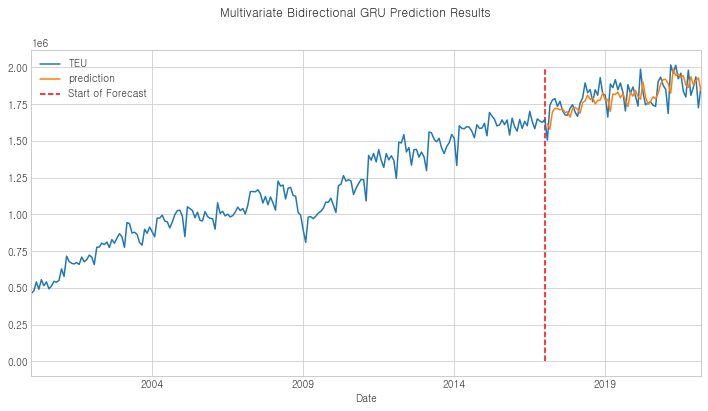

In [88]:
prediction = model.predict(X_test)
prediction_copies_array = np.repeat(prediction,9, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),9)))[:,0]
original_copies_array = np.repeat(y_test,9, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),9)))[:,0]

future_forecast_dl = pred
future_forecast_dl = pd.DataFrame(future_forecast_dl, index=test_data[1:].index, columns=['prediction'])

mse = mean_squared_error(original, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(original, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(pred, original))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs((original-pred)/original)*100)
print('MAPE: '+str(mape))

full_data_evaluation = pd.concat([data['TEU'], future_forecast_dl], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01',0,2000000,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 12, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle('Multivariate Bidirectional GRU Prediction Results')